# <center>Spectral Clustering Implementation and Appliacation </center>

### <center>Qi Wang and Hanqiu Xia</center>









## <center>Abstract<center>

The main idea of spectral clustering is to use the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction and then perform clustering in fewer dimensions. Spectral clustering is widely used in image segmentation. In this project, we investigate the normalized spectral decomposition algorithm from the paper "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Their algorithm improved upon the existing spectral clustering algorithm by resolving the issues of inconsistent algorithms of using eigenvectors as well as providing evidence for a reasonable clustering. We implement the algorithm using Python with considering both idea and special cases. We also optimize the Python codes by applying vectorization, Cython, Just-In-Time compiling and parallelization. Finally, we test the algorithm on simulated and real datasets and compare the experimental results with those of k-means clustering to see if spectral clustering dramatically improves the results.

## 1.  Background

The research paper we choose is "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Spectral clustering is inspired by the the idea of spectral graph partitioning, in which we use the first two eigenvectors of a similarity matrix derived from the distance between points to partition the graph into exactly two parts. It has overwhelming advantage in image segmentation. However, in previous literatures, authors are inconsistent in choosing and deriving eigenvectors. One of the achievement of A. Ng, M. Jordan, and Y. Weiss's paper is standardizing and simplifying the algorithem of spectral clustering[1]: utilising the  first $k$ largest eigenvectors to cluster points into  $k$ subsets. The detailed algorithm is as follows:

Suppose we have a set of $n$ points $S = \{ s_1, \ldots, s_n\}$ in ${\rm I\!R}^{m}$, and we want to cluster them into $k$ groups.

 **Step 1:** Construct the affinity matrix $A \in{\rm I\!R}^{n\times n} $,  each element in A is defined as $A_{ij} = exp(-||s_i-s_j||^2/2\sigma^2)$ and $A_{ii}=0$,  for $i, j = 1,\ldots, n$. 

**Step 2:** Define $D$ to be the diagonal matrix with $D_{ii} =\sum_{j=1}^{n} A _{ij}$, and form the normalized Laplacian matrix $L = D^{-1/2}AD^{-1/2}$.

**Step 3:** Capture the fist $k$ largest eigenvectors of $L, x_1, x_2,  \ldots, x_k, x_i \in {\rm I\!R}^{n} $ and form the matrix $X = [x_1 ~x_2 ~\cdots ~x_k ] \in  {\rm I\!R}^{n\times k}.$

**Step 4:** Create the new normalized matrix $Y \in {\rm I\!R}^{n\times k}$ from $X$, defined as $Y_{ij}= X_{ij}/(\sum_{j=1}^{n}X_{ij}^2)^{1/2}$.

** Step 5:** Consider $Y$ to be a set of $n$   points that need to be clustered now, apply K-means or any other algorithm that can minimize distortion to cluster $Y$. 

** Step 6:**  Assign the original point $s_i$ in to cluster $j$ if and only if the $i$th-row of $Y$ was distributed to cluster $j$  in previous step.       


Comparing to the straighforward K-means clustering, this algorithm improves the performance by normalizing affinity matrix $A$ (to matrix $L$) and matrix $X$ that is constructed by the $k$ largest eigenvectors of $L$. Especially for the dataset with two dimensions that is not correpsonding to convex region (like circular graph and moon-like graph), spectral clustering results in more reasonable clustering than K-means. We will implement this experiment in later parts.  This report is organized as follows: In part 2, we implement the spectral clustering algorithm on both idea and special cases. Next, we practice the unit test and optimize coding in part 3 and 4, respectively.  Part 5 applies the algorithm in real and simulated datasets and compare the results with k-means clustering. Part 6 discusses our findings.





## 2. Implementation
We write four functions to implement the algorithm. The first two functions, `GenerateData` and `CreateCircle`, simluate data in idea case and special case respectively. In the third function `CalculateAffinity`, we calculate the affinity matrix which is exactly the first step in the above described algorithm. The last function `Spectral` is the core function, which implements Step 2 to 6 in the algorithm and returns the labels for assigning each point into cluster.

We choose to show the JIT compiling code below, since this is the fastest code for all of our functions after optimizing efforts. We will provide details about the comparison among different optimization method in part 4. 

### 2.1 Simulate Data
We create two functions to simulate datasets. Our first function `GenerateData` generates data that falls under the ideal case. The ideal case denotes the situation when the clusters are clearly partitioned and are far apart from each other. The proposed mechanism works very well in this case and will result in an exact match to the true clustering of the original data.  We can choose to generate a certain number of clusters with the desired sample size using this function.

In the function `CreateCircle`, we generate data in two dimensions that do not conrrespond to convex region. To be specific, this function will generate a chosen number of clusters each with 100 points that form circles. This data will be used to test the special case where spectral clustering is expected to perform better than some other methods such as K-means clustering. Spectral clustering will form tight clusters around well-separated points on the surface of the sphere according to their "true" cluster[1].



In [3]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

import pandas as pd
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


import pandas as pd

- Simulate Data for Ideal Case

In [4]:
import numba
from numba import jit

In [5]:
@jit
def GenerateData_jit(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Simulate Data for Special Case

In [6]:
@jit
def CreateCircle_jit(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

### 2.2 Algorithm Implementation

The next function `CalculateAffinity` will perform the first step of the Algorithm to calculate the affinity matrix defined as $A_{ij} = exp(-||s_i-s_j||^2/2\sigma^2)$ such that $A_{ii}=0$,  for $i, j = 1,\ldots, n$. 

In [7]:
@jit
def CalculateAffinity_jit(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


The last function `Spectral` performs Step 2 to Step 6 of the algorithm. The function first calculates the degree matrix, from which it calculates the normalized lapacian matrix. Afterwards, we find the k largest eigenvectors and form the new normalized matrix. At last, the function performs the regular k-means clustering using the new matrix and assign points to clusters.

In [23]:
@jit
def Spectral_jit(k, A):
    """Create cluster labels for points from k-means using the normalized matrix Algorithm Step 2-6. 

    Step 2: Define D to be the diagonal matrix whose (i,i)-element is the sum of A's i_th
row,and construct the matrix L =D^(-l/2)AD^(-l/2).

    Step 3: Find Xl , X2 , ... , Xk, the k largest eigenvectors of L (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix X = [XIX2 . . . Xk) E R^(nxk) by stacking the eigenvectors in columns.

    Step 4: Form the matrix Y from X by renormalizing each of X's rows to have unit length (i.e. Y_ij = X_ij/sum(X_ij^2)^(1/2).

    Step 5: Treating each row of Y as a point in R^k , cluster them into k clusters via K-means or any other algorithm.

    Step 6: Finally, assign the original point s_i to cluster j if and only if row i of the matrix Y was assigned to cluster j.


        Args:
            k: The number of clusters desired.
            A: The affinity matrix.

        Returns:
            A numpy array of the cluster assignment for each point.

    """
    # compute the degree matrix
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

## 3. Unit Testing
We use pytest-ipynb to conduct unit testing. The testing file is named `test*.ipynb`, and by running through the file in terminal by the command `py.test`, the unit testing is performed automatically and runs tests all the cells in the file. All tests are passed for all of our functions. In each function, we conduct several tests for common cases to assert that each function creates data in the correct format and correct dimension to test for general and special cases. And by setting the seed, we can confirm that each function creates the correct matrix. For each function, there are two tests for edge cases. For the edge cases, all functions will generate an error for the incorrect inputs such as non-arrays or 0s. 

## 4. Optimization

We use vectorization, cython, Just-In-Time compiling and parallelization to optimize our code. The code used to perform optimization and calculate speed-up ratio can be found in cell 4 to 53 in the `ProjectCode.ipynb` notebook.

The first optimization we implement is vectorization. The possible bottlenecks for data generating functions and affinity calculation functions are that there are multiple for loops in the functions. To eliminate the use of for loops, we vectorize the code to improve the performance. If we have a large dataset to perform clustering, the runtime will improve consistently. Since for our test case, we only need a sample size of around 80, the improvement in runtime is not apparent. There's not much we can do with `Spectral` and thus we only perform the following methods for this function.

We also use Just-In-Time compiling from the package `numba` to optimize code bottlenecks identified by profiling. It generates optimized machine code from the LLVM compiler infrastructure. JIT in Python would have similar performance to C/C++ without switching languages. For each function, JIT improves the runtime significantly and even faster than the vectorized code for large numbers of data points. 

We also use Cython to optimize the runtime. Cython is an "optimizing static compiler " that combines Python with C to generate optimized code[2]. Cython does not perform quite as well compared to the above two methods. It only improves the runtime by a bit.

Lastly we use `concurrent.features` to perform multiple core programming based on the vectorized python. Since our algorithm is not quite complicated and is not applied to a huge dataset, parallezing does not enhance the performace.

The table below summarizes the speed-up ratios for different optimization methods for each function. We run each function multiple times and record the average runtime in the table. For `GenerateData`, we set the input $n$ (data points in each cluster) as 2000 and the number of clusters as 4, and we can see that JIT is significantly faster than the other algorithms. We set $n$ (numbers of clusters) as 3 when runing the CreateCircle function. For `CalculateAffinity`, we continue to use the data generated from `GenerateData` and find that JIT is still the best option. For the `Spectral` function, we input the affinity matrix calculated from last step and we still have JIT as the fastest. We can see that JIT performs the best consistently across all functions. Thus we choose to use JIT in our applications.




In [32]:
import pandas as pd
t1 = pd.read_csv('opt.csv',)
t1.head()

,Function,Vectorization,JIT,Cython,Parallelization
0,GenerateData,6,40.0,7.0,0.25
1,CreateCircle,2,5.0,1.6,0.07
2,CalculateAffinity,57,145.0,1.2,43.00
3,Spectral,NaN,2.1,1.1,0.70


## 5. Application and Comparison

Now, we apply our algorithm to "real" problems to both the ideal case and the special case. And we also compare the results with K-means clustering (We use `KMeans` from the `sklearn` package in Python to fulfill this purpose).

### 5.1 Concept  for K-Means

Before staring the comparison, we first introduce the basic idea of K-means. 

The purpose of k-means clustering is to assign $n$ observations $X_1,\ldots,X_n$ into $k$ clusters, so that we can approximately minimize the dissimilarities $d(X_i,X_j)=||X_i-X_j||_2^2$ between data points within each cluster. In other word, we try to approximately minimize the within-cluster scatter, which is defined as 

$$W=\dfrac{1}{2}\sum^K_{k=1}\dfrac{1}{n_k}\sum_{C(i)=k}\sum_{C(j)=k}||X_i-X_j||_2^2=\sum_{k=1}^K\sum_{C(i)=k}||X_i-\bar{X_k}||_2^2$$,

 where $X_k$ is the average of points in group $k$. And the right-hand side expression is known as within-cluster variation. To start the k-means algorithm, user has to specify an initial guess $c_1,\ldots,c_k$ for the centroids of those k clusters. Then the k-means algorithm will start the iteration to minimize the enlarged criterion, $\sum_{k=1}^{K}\sum_{C(i)=k}||X_i-c_k||_2^2$. For each iteration, there are two steps to adjust distance and new clusters. K-means algorithm will first assign each points to its closest centroid to form the first set of clusters. A new centroid for each cluster will then be calculated, which is the average of points in group we set in last step. K-means algorithm will then repeat those two steps until there is no further change for the points assignment. 

In order to avoid the biased effect of choosing the initial centers just once, we usually choose the initial centers several times, and run the above algorithem for these centers, and then choose the clustering results with the samllest within-cluster variation.

### 5.1 Ideal Case

We apply spectral clustering algorithm on the dataset simulated from `GenerateData`. In the example, we first simulate data with 4 clusters, that are far apart from each other. Then we use spectral clustering (`Spectral`) and K-means (`KMeans`) to distribute them into 4 subsets.

In [34]:
k=4
data = GenerateData_jit(k)
affinity = CalculateAffinity_jit(data)

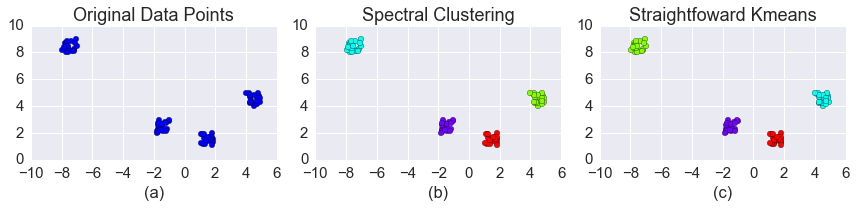

In [35]:
# Results from spectral clustering
IDX= Spectral_jit(k,affinity)


# Results from k-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_k=np.asarray(ID) 



# Draw graph
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')
plt.xlabel("(a)")

plt.subplot(1,3,2)
colors = plt.cm.hsv(np.linspace(0, 1, k+1))
for i in range(len(IDX)):
    for j in range(k):
        if IDX[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Spectral Clustering')
plt.xlabel("(b)")


plt.subplot(1,3,3)
for i in range(len(IDX_k)):
    for j in range(k):
        if IDX_k[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.title('Straightfoward Kmeans')
plt.xlabel("(c)")

plt.tight_layout()

**Figure 1:** Clustering examples on idea case. (a) The scatter plot for the data sets. (b) The clutsering results from spectral clustering. (c) The result of using K-means directly. (Clusters are indicated with different colors).


In this example, we have 4 even-size clusters that are far apart from each other. And each of them is in the convex region, i.e.,  for every pair of points within the region, every point on the straight line segment that joins the pair of points is also within the region.  From Figure 1(b) and (c), we can see both the spectral and K-means could assign points into the reasonable groups, though the cluster labels are slightly different. Since the aim of K-means is to minimize within-cluster sum-of-squares, it is undoubtable that K-means would assign the most internally coherent groups together and provide the same result as spectral clustering does in this particular case.

### 5.2 Special Case

Besides the ideal case such that points are far apart in convex region, we also apply the algorithm to the special case, in which points do not correspond to covex regions. We use two dataset for this case, one is the circular dataset we generate through our own function `CreateCirle`, another one is the moon-shape dataset from Jain and Law's paper [3]. We compare the results with those generated from K-means as well.

- Circular data

In [37]:
k=3
data = CreateCircle_jit(3)
affinity = CalculateAffinity_jit(data)

In [38]:
# Result from spectral clustering
IDX= Spectral_jit(k,affinity)

# Result from k-means
clust_result = KMeans(n_clusters=3, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_k=np.asarray(ID) 



- Moon-shape data

In [39]:
moon = np.loadtxt('jain.txt')
data_m = moon[:,0:2]
affinity = CalculateAffinity_jit(data_m)
k_m = 2

In [40]:
# Result from spectral clustering
IDX_m=Spectral_jit(k_m,affinity)

# Result from k-means
clust_result = KMeans(n_clusters=k_m, random_state=10)
cluster_labels = clust_result.fit_predict(data_m)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX_mk=np.asarray(ID) 


- Draw Graph

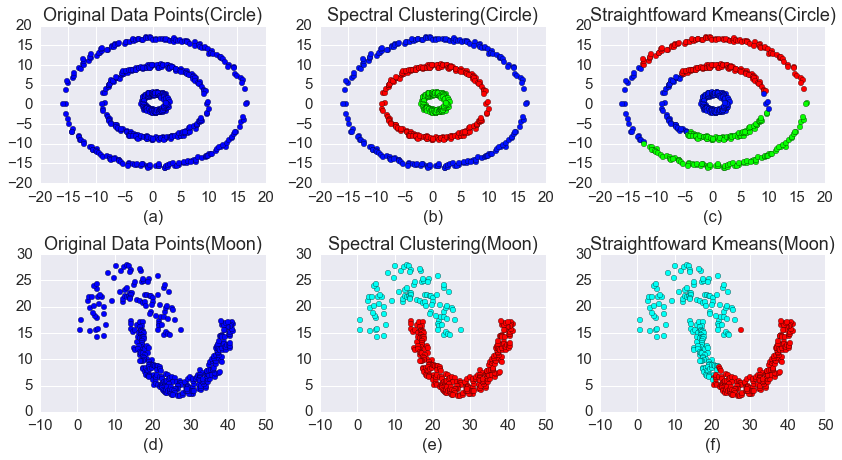

In [41]:
# Graph for circular data
plt.figure(figsize=(12,6.5))
plt.subplot(2,3,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.axis([-20,20,-20,20])
plt.xlabel("(a)")
plt.title('Original Data Points(Circle)')

plt.subplot(2,3,2)
colors = plt.cm.hsv(np.linspace(0, 1, k+1))
for i in range(len(IDX)):
    for j in range(k):
        if IDX[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.axis([-20,20,-20,20])
plt.xlabel("(b)")
plt.title('Spectral Clustering(Circle)')



plt.subplot(2,3,3)
for i in range(len(IDX_k)):
    for j in range(k):
        if IDX_k[i] == j:
            plt.scatter(data[i,0],data[i,1],c=colors[j] ,s=30)
plt.axis([-20,20,-20,20])
plt.xlabel("(c)")
plt.title('Straightfoward Kmeans(Circle)')




# Graph for moon-like data data
plt.subplot(2,3,4)
plt.scatter(data_m[:,0],data_m[:,1],s=30)
plt.xlabel("(d)")
plt.title('Original Data Points(Moon)')

plt.subplot(2,3,5)
colors = plt.cm.hsv(np.linspace(0, 1, k_m+1))
for i in range(len(IDX_m)):
    for j in range(k_m):
        if IDX_m[i] == j:
            plt.scatter(data_m[i,0],data_m[i,1],c=colors[j] ,s=30)
plt.xlabel("(e)")
plt.title('Spectral Clustering(Moon)')


plt.subplot(2,3,6)
for i in range(len(IDX_mk)):
    for j in range(k_m):
        if IDX_mk[i] == j:
            plt.scatter(data_m[i,0],data_m[i,1],c=colors[j] ,s=30)
plt.xlabel("(f)")
plt.title('Straightfoward Kmeans(Moon)')


plt.tight_layout()

**Figure 2:** Clustering example for special case. (a) Scatter plot for circular dataset. (b) Clustering results from spectral clustering for circular dataset. (c) K-means result for circular dataset. (d) Scatter plot for moon-like dataset. (e) Clustering results from spectral clustering for moon-like dataset. (f) K-means result for moon-like dataset.



In this case, we have two groups of datasets, both of them do not correspond to the convex region. In the first group, we have three circles that share the same center, but with different radius. From the Figures 2(b) and 2(c), the spectral clustering classifies each circle as a different cluster, which is consistent with human logic, while K-means produces an unsatisfactory clustering. This is because K-means tries to figure out the clusters with the minimal within-cluster sum-of-square, and always assume that clusters are convex, however, this is not the case in this example.

In the second group, we have two moon shaped clusters. Just as we expected, spectral clustering performs well, while K-means still fails to classify them clearly with the same reason above.

## 6. Discussion

In this report, we implement the algorithm suggested by Ng, and we also successfully reproduce the results in Ng's paper[1]. The main idea of spectral clustering is making use of the top $k$ eigenvectors of the similarity matrix to cluster points into $k$ subsets. Similarity matrix indicates the relative similarity of each pair of points in the dataset, and using the first $k$ eigenvectors of the matrix also performs the dimension reduction effectively. Although we run K-means as one of the steps in the algorithm of spectral clustering, the normalization of similarity matrix improves the performance of algorithm, especially for the dataset not corresponding to the convex region. Comparing to spectral clustering, the direct usage of K-means assigns points by minimizing the within cluster sum-of-square, which is unnormalized. And for very high-dimensional spaces, Euclidean distance tends to become inflated, therefore, K-means results in worse clustering for dataset in unconvex regions than spectral clustering.

## References

[1] A. Ng, M. Jordan, and Y. Weiss. On Spectral Clustering: Analysis and an algorithm. Advances in Neural Information Processing. Vol. 14, No. 2. (2001), pp. 849-856

[2] Chan, Cliburn. 18D_Cython.ipynb. STA663 Lecture Notes. (2016)

[3] A. Jain and M. Law, Data clustering: A user's dilemma. Lecture Notes in Computer Science, 2005. 3776: pp. 1-10. 